In [58]:
path = '/content/drive/MyDrive/Colab Notebooks/lyrics toxicity/'

In [85]:
#import packages
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sn
%matplotlib inline
import re
import sys
import warnings
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import joblib

In [60]:
#needed for DNN 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from keras.regularizers import l2,l1
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
# from keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import models
from sklearn import preprocessing
from keras import layers
from tensorflow.keras.layers import LSTM,GRU,Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle

In [61]:

df=pd.read_csv(path +  'data/cleaned_df.csv', encoding='utf-8')
# df =  shuffle(df).reset_index(drop=True)
df.head()

,seq,label,toxicity,clean_lyrics
0,"No, no\r\nI ain't ever trapped out the bando\r...",0.626,toxic,no i ever trap bando but oh lord get wrong i k...
1,"The drinks go down and smoke goes up, I feel m...",0.630,toxic,the drink go smoke go i feel get let go my car...
2,She don't live on planet Earth no more\r\nShe ...,0.240,toxic,she live planet earth she find love venus word...
3,"Trippin' off that Grigio, mobbin', lights low\...",0.536,toxic,trippin grigio mobbin light low trippin grigio...
4,"I see a midnight panther, so gallant and so br...",0.371,toxic,i see midnight panther gallant brave i find i ...


In [62]:
# df_copy=df.copy()
# tox_df=df_copy.loc[(df_copy.toxicity=='toxic')] 

# not_toxic_df=df_copy.loc[(df_copy.toxicity=='non_toxic')]

# print("toxic class shape is {tox_shape}\nNon bully text's shape is {not_toxic_shape}".format(tox_shape = tox_df.shape ,not_toxic_shape=not_toxic_df.shape))

In [63]:
# df1= tox_df[tox_df['clean_lyrics'].map(len) < 1000]
# tox_df = tox_df.sample(n=20000,replace=True)

In [64]:
# df = tox_df.append(not_toxic_df)
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

In [65]:
print(df.shape)

(158353, 4)


In [66]:
# label encoding for output

sample_data = [2000,5000,10000]

def label_encoding(category,bool):
  le = preprocessing.LabelEncoder()
  le.fit(category)
  encoded_labels = le.transform(category)
  labels = np.array(encoded_labels) # Converting into numpy array
  class_names =le.classes_ ## Define the class names again
  if bool == True:
    print("\n\t\t\t Label Encoding ","\nClass Names:-->",le.classes_)
    for i in sample_data:
      print(category[i],' ', encoded_labels[i],'\n')
    return labels

labels = label_encoding(df.toxicity,True)


			 Label Encoding  
Class Names:--> ['non_toxic' 'toxic']
toxic   1 

non_toxic   0 

toxic   1 



In [89]:
#split the data in train, validation, test

def dataset_split(headlines,category):

    X,X_test,y,y_test = train_test_split(headlines,category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(headlines),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test


In [90]:
df.clean_lyrics=df.clean_lyrics.astype(str)

X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(df.clean_lyrics,labels)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 158353 
	Training		 128265 
	Test			 15836 
	Validation		 14252


In [69]:
#define perameters for GRU and padding and tokenization
vocab_size =50000
embedding_dim = 128
max_length = 300
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [70]:
# Train Data Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train.values)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train.values)
train_padded = pad_sequences(train_sequences,padding=padding_type, maxlen=max_length)

In [71]:
#Tokenizer Info
(word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
#insightful info about tokens
def tokenizer_info(mylist,bool):
  ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
  for w,c in ordered[:10]:
    print(w,"\t",c)

#Print all the information
print("Words --> Counts:")
tokenizer_info(word_counts,bool =True )
print("\nWords --> Documents:")
tokenizer_info(word_docs,bool =True )
print("\nWords --> Index:")
tokenizer_info(word_index,bool =True )    
print("\nTotal Documents -->",document_count)
print(f"Found {len(word_index)} unique tokens")

Words --> Counts:
i 	 1317218
and 	 272119
get 	 219570
love 	 214104
you 	 208830
know 	 187153
go 	 162141
like 	 150852
oh 	 126677
come 	 117630

Words --> Documents:
i 	 110371
and 	 82418
know 	 64528
you 	 61024
go 	 58187
get 	 57258
love 	 55446
like 	 51655
but 	 51472
see 	 47984

Words --> Index:
soafer 	 115089
elizabethan 	 115088
disrepectin 	 115087
gaal 	 115086
graffitit 	 115085
jowells 	 115084
everythign 	 115083
meaninglessness 	 115082
chinchillas 	 115081
projs 	 115080

Total Documents --> 128265
Found 115089 unique tokens


In [72]:
def padded_headlines(original,encoded,padded):
  print("\n\t\t\t Encoded Sequences ","\n")  
  print(original,"\n",encoded) 
  print("\n\t\t\t Paded Sequences \n",original,"\n",padded)

padded_headlines(X_train[10],train_sequences[10],train_padded[10])


			 Encoded Sequences  

won play simple melody like mother sing one good old fashion harmony play simple melody musical demon set honey dreamin won play rag just change classical nag sweet beautiful drag if play copy tune that choppy get applause and simply i wanna listen rag play that good old fashion harmony oh play a simple melody play copy tune choppy you get applause i wanna rag ragtime melody 
 [18, 128, 16, 48, 2, 7, 18, 131, 277, 130, 71, 57, 83, 2, 1784, 689, 59, 892, 1601, 15, 62, 2, 7, 15, 8356, 48, 179, 194, 6072, 691, 179, 576, 129, 29, 13, 773, 1362, 36, 39, 18, 3673, 1150, 49, 179, 15, 8, 45, 495, 905, 81, 131, 7, 2, 453, 179, 8, 2, 57, 113, 150, 3, 131, 257, 2, 71, 510, 402, 76, 1202, 319, 3072, 343, 15, 2, 71, 130, 3, 4, 188, 14, 129, 18, 131, 277, 2, 93, 59, 97, 14, 129, 18, 131, 277, 16, 48, 2, 7, 18, 131, 277, 130, 71, 57, 83, 2, 1784, 689, 59, 843, 15, 2, 71, 130, 63, 2380, 25, 4411, 4183, 9, 2, 342, 4287, 4438, 15, 239, 2, 851, 4, 1002, 25, 6, 131, 1441, 447, 38

In [73]:
# Validation Data Tokenization
validation_sequences = tokenizer.texts_to_sequences(X_valid.values)
validation_padded = pad_sequences(validation_sequences,padding=padding_type, maxlen=max_length)

In [74]:
# Test Data Tokenization
test_sequences = tokenizer.texts_to_sequences(X_test.values)
test_padded = pad_sequences(test_sequences,padding=padding_type, maxlen=max_length)

In [75]:
train_label_seq = y_train
valid_label_seq = y_valid
testing_label_seq = y_test

In [76]:
accuracy_threshold = 0.99
vocab_size = 50000
embedding_dim=128
max_length = 300
num_category = 2
opt=RMSprop(0.001)

In [77]:
keras.backend.clear_session()
#callback function for early stopping
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()

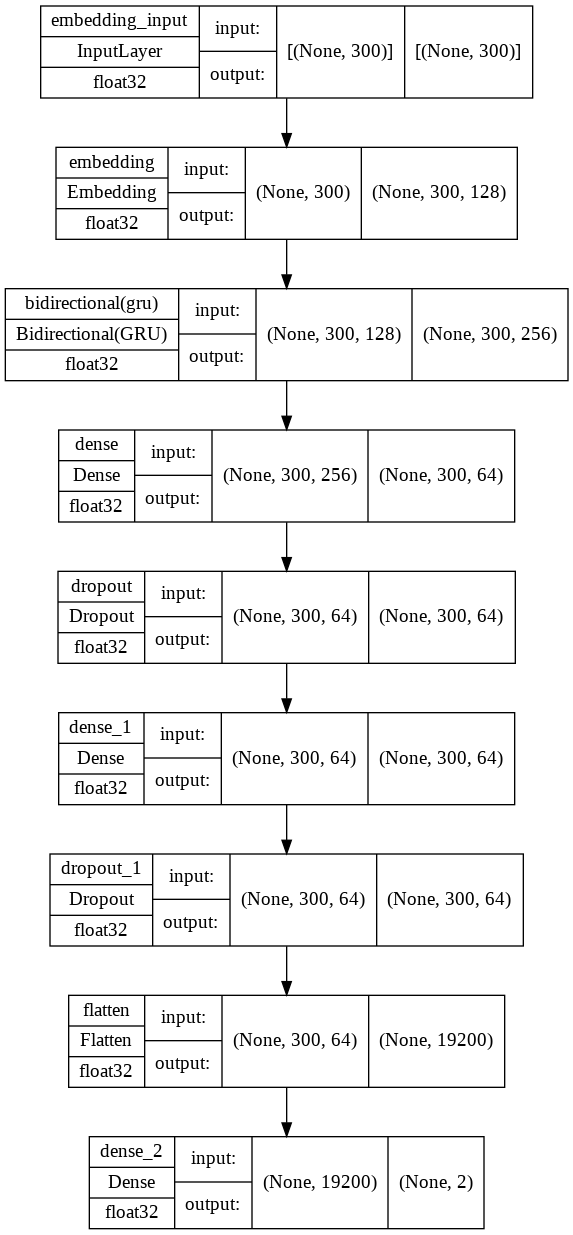

In [78]:
filepath = path + "model/BidGruModel.h5"

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.1, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.0001, cooldown=1, min_lr=0.000001)
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
callback_list = [acc_callback, checkpoint,reduceLROnPlat]
adam = RMSprop(lr=1e-2, epsilon=1e-08)


BGRU_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]),
    tf.keras.layers.Bidirectional(GRU(128,return_sequences=True,dropout=0.2)),
    # tf.keras.layers.Bidirectional(GRU(64, dropout = 0.2, recurrent_dropout = 0.2)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_category, activation='sigmoid')
])

tf.keras.utils.plot_model(BGRU_model,show_shapes=True,show_dtype=True)

In [79]:
BGRU_model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
BGRU_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          6400000   
                                                                 
 bidirectional (Bidirectiona  (None, 300, 256)         198144    
 l)                                                              
                                                                 
 dense (Dense)               (None, 300, 64)           16448     
                                                                 
 dropout (Dropout)           (None, 300, 64)           0         
                                                                 
 dense_1 (Dense)             (None, 300, 64)           4160      
                                                                 
 dropout_1 (Dropout)         (None, 300, 64)           0         
                                                        

In [80]:
num_epochs = 3
batch = 128

BGRU_model_history = BGRU_model.fit(train_padded, train_label_seq, 
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, valid_label_seq), 
                    verbose=1,
                    callbacks = callback_list)

Epoch 1/3
1002/1003 [============================>.] - ETA: 0s - loss: 0.3353 - accuracy: 0.9398
Epoch 1: val_accuracy improved from -inf to 0.94464, saving model to /content/drive/MyDrive/Colab Notebooks/lyrics toxicity/model/BidGruModel.h5
1003/1003 [==============================] - 63s 59ms/step - loss: 0.3352 - accuracy: 0.9399 - val_loss: 0.4221 - val_accuracy: 0.9446 - lr: 0.0100
Epoch 2/3
1002/1003 [============================>.] - ETA: 0s - loss: 0.2538 - accuracy: 0.9429
Epoch 2: val_accuracy did not improve from 0.94464
1003/1003 [==============================] - 57s 56ms/step - loss: 0.2538 - accuracy: 0.9429 - val_loss: 0.2164 - val_accuracy: 0.9446 - lr: 0.0100
Epoch 3/3
1003/1003 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.9429
Epoch 3: val_accuracy did not improve from 0.94464
1003/1003 [==============================] - 53s 53ms/step - loss: 0.2720 - accuracy: 0.9429 - val_loss: 0.2151 - val_accuracy: 0.9446 - lr: 0.0100


In [81]:
#confusion matrix
def conf_matrix(y_pred,classfier,directory,filename):

  cm = confusion_matrix(y_test, y_pred) 
# Transform to df for easier plotting
  
  cm_df = pd.DataFrame(cm,
                       index = ['non_tox', 'tox'], 
                       columns = ['non_tox', 'tox'])
  plt.figure(figsize=(8,6))
  sn.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
  plt.title('\n'+classfier+'Accuracy: {0:.2f}'.format(accuracy_score(testing_label_seq, y_pred)*100))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.xticks(rotation = 45)
  plt.yticks(rotation = 45)
  # plt.savefig("/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/visualization/result_analysis/"+directory+"/"+filename+".png")
  plt.show()
  plt.close()

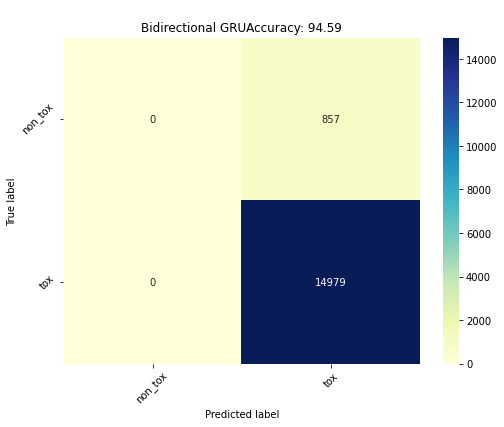

In [82]:
#make predictions

model = load_model(path+"model/BidGruModel.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
conf_matrix(y_pred,"Bidirectional GRU","BiGru","Bi_Gru_confusion_matrix")

In [83]:
MLA = {
     'Bidirectional GRU' : model,
    #  'Bidirectional LSTM' : RNN_model,
    #  'LSTM' : LSTM_model,
    #  'C_LSTM' : C_LSTM_model, 
}

In [93]:
from sklearn.metrics import *
columns = []
compare = pd.DataFrame(columns = columns)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=2
row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    predicted = alg.predict(test_padded)
    y_pred = np.argmax(predicted, axis=1)
    micro_averaged_recall = recall_score(testing_label_seq, y_pred, average = 'micro')
    macro_averaged_f1 = f1_score(testing_label_seq, y_pred, average = 'micro')
    compare.loc[row_index,'Name'] = MLA_name
    compare.loc[row_index, 'Test Accuracy'] = accuracy_score(testing_label_seq,y_pred)
    compare.loc[row_index, 'Precision'] = precision_score(testing_label_seq, y_pred)
    compare.loc[row_index, 'Recall'] = micro_averaged_recall
    compare.loc[row_index, 'F1 Score'] = macro_averaged_f1
    # compare.loc[row_index, 'auc Score'] = auc_score
    row_index+=1
    
compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
compare

,Name,Test Accuracy,Precision,Recall,F1 Score
0,Bidirectional GRU,0.945883,0.945883,0.945883,0.945883
